In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import requests
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
from io import BytesIO
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input
import matplotlib.pyplot as plt

In [5]:
# 이미지 저장 디렉토리
img_dir = "/content/drive/MyDrive/ACAC/images"
os.makedirs(img_dir, exist_ok=True)

# landmark_id → 여행지명 매핑 테이블
landmark_name_map = {
    101: "Louvre Museum",
    102: "Eiffel Tower",
    103: "Big Ben",
    104: "Colosseum",
    105: "Sydney Opera House",
    106: "Taj Mahal",
    107: "Great Pyramid of Giza",
    108: "Golden Gate Bridge",
    109: "Statue of Liberty",
    110: "Sagrada Familia"
}

sample_data = [
    {"id": "louvre_1", "url": "https://upload.wikimedia.org/wikipedia/commons/8/87/Louvre_Museum_Wikimedia_Commons.jpg", "landmark_id": 101},
    {"id": "eiffel_1", "url": "https://upload.wikimedia.org/wikipedia/commons/a/a8/Tour_Eiffel_Wikimedia_Commons.jpg", "landmark_id": 102},
    {"id": "bigben_1", "url": "https://upload.wikimedia.org/wikipedia/commons/3/3a/Big_Ben_2012-07-16.jpg", "landmark_id": 103},
    {"id": "colosseum_1", "url": "https://upload.wikimedia.org/wikipedia/commons/d/d7/Colosseum_in_Rome%2C_Italy_-_April_2007.jpg", "landmark_id": 104},
    {"id": "sydney_opera_1", "url": "https://upload.wikimedia.org/wikipedia/commons/3/3e/Sydney_Opera_House_Sails.jpg", "landmark_id": 105},
    {"id": "tajmahal_1", "url": "https://upload.wikimedia.org/wikipedia/commons/d/da/Taj-Mahal.jpg", "landmark_id": 106},
    {"id": "pyramids_1", "url": "https://upload.wikimedia.org/wikipedia/commons/e/e3/Kheops-Pyramid.jpg", "landmark_id": 107},
    {"id": "goldengate_1", "url": "https://upload.wikimedia.org/wikipedia/commons/0/0c/GoldenGateBridge-001.jpg", "landmark_id": 108},
    {"id": "statue_liberty_1", "url": "https://upload.wikimedia.org/wikipedia/commons/a/a1/Statue_of_Liberty_7.jpg", "landmark_id": 109},
    {"id": "sagradafamilia_1", "url": "https://upload.wikimedia.org/wikipedia/commons/0/0e/Sagrada_Familia_01.jpg", "landmark_id": 110},
]

df = pd.DataFrame(sample_data)
df.to_csv("/content/drive/MyDrive/ACAC/train_sample.csv", index=False)
print("✅ train_sample.csv 저장 완료")

✅ train_sample.csv 저장 완료
✅ landmark_name_map.csv 저장 완료


In [52]:
# CSV 로드
df = pd.read_csv("/content/drive/MyDrive/ACAC/train_sample.csv")

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/92.0.4515.131 Safari/537.36"
}

images = []
labels = []

# 3. 이미지 다운로드 + 전처리
for i, row in df.iterrows():
    url = row['url']
    landmark_id = row['landmark_id']
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()  # HTTP 에러 있으면 예외 발생

        img = Image.open(BytesIO(response.content)).convert("RGB")
        img = img.resize((300, 300))
        img_np = np.array(img, dtype=np.float32) / 255.0
        images.append(img_np)
        labels.append(landmark_id)

        save_path = os.path.join(img_dir, f"{row['id']}.jpg")
        img.save(save_path)
    except Exception as e:
        print(f"Error downloading {url}: {e}")

print(f"[DEBUG] Loaded {len(images)} images")
print(f"[DEBUG] Labels sample: {labels[:10]}")
print(f"[DEBUG] Unique label count: {len(set(labels))}")

# 빈 상태 체크
if len(images) == 0 or len(labels) == 0:
    raise ValueError("No image or label data loaded. Check dataset path and image availability.")

Error downloading https://upload.wikimedia.org/wikipedia/commons/8/87/Louvre_Museum_Wikimedia_Commons.jpg: 404 Client Error: Not Found for url: https://upload.wikimedia.org/wikipedia/commons/8/87/Louvre_Museum_Wikimedia_Commons.jpg
Error downloading https://upload.wikimedia.org/wikipedia/commons/3/3a/Big_Ben_2012-07-16.jpg: 404 Client Error: Not Found for url: https://upload.wikimedia.org/wikipedia/commons/3/3a/Big_Ben_2012-07-16.jpg
Error downloading https://upload.wikimedia.org/wikipedia/commons/d/d7/Colosseum_in_Rome%2C_Italy_-_April_2007.jpg: 404 Client Error: Not Found for url: https://upload.wikimedia.org/wikipedia/commons/d/d7/Colosseum_in_Rome%2C_Italy_-_April_2007.jpg
Error downloading https://upload.wikimedia.org/wikipedia/commons/3/3e/Sydney_Opera_House_Sails.jpg: 404 Client Error: Not Found for url: https://upload.wikimedia.org/wikipedia/commons/3/3e/Sydney_Opera_House_Sails.jpg
Error downloading https://upload.wikimedia.org/wikipedia/commons/0/0e/Sagrada_Familia_01.jpg: 40

In [53]:
# 배열 변환 및 레이블 인코딩
X = np.array(images)
label_set = sorted(list(set(labels)))
label2idx = {label: idx for idx, label in enumerate(label_set)}
y = np.array([label2idx[l] for l in labels])
y = to_categorical(y, num_classes=len(label_set))

# 데이터 증강 설정
datagen = ImageDataGenerator(
    horizontal_flip=True,            # 좌우 반전
    rotation_range=15,               # -15 ~ +15도 회전
    width_shift_range=0.1,           # 좌우 이동
    height_shift_range=0.1           # 상하 이동
)

datagen.fit(X)

In [54]:
# 5. LeNet 모델 정의
class LeNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()
        self.add(Input(shape=input_shape))
        self.add(Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=input_shape, padding='same'))
        self.add(AveragePooling2D(pool_size=(2, 2)))
        self.add(Conv2D(16, kernel_size=(5, 5), activation='tanh'))
        self.add(AveragePooling2D(pool_size=(2, 2)))
        self.add(Flatten())
        self.add(Dense(120, activation='tanh'))
        self.add(Dense(84, activation='tanh'))
        self.add(Dense(num_classes, activation='softmax'))
        self.compile(optimizer='adam', loss=categorical_crossentropy, metrics=['accuracy'])

In [55]:
# 모델 학습
model = LeNet(input_shape=(300, 300, 3), num_classes=len(label_set))
model.fit(X, y, epochs=3)

epochs = 15
batch_size = 4  # 데이터가 적으니까 작게 설정

history = model.fit(
    datagen.flow(X, y, batch_size=batch_size),
    steps_per_epoch=len(X) // batch_size if len(X) >= batch_size else 1,
    epochs=epochs,
    verbose=1
)

# 테스트 이미지 분류 및 추천 결과 출력
test_img = np.expand_dims(images[0], axis=0)
pred = model.predict(test_img)[0]
top5_idx = np.argsort(pred)[-5:][::-1]

print("Top-5 추천 여행지:")
for idx in top5_idx:
    lid = label_set[idx]
    prob = pred[idx]
    name = landmark_name_map.get(lid, "Unknown")
    print(f"여행지명: {name}, Landmark ID: {lid}, Confidence: {prob:.2f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2000 - loss: 1.7689
Epoch 2/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6000 - loss: 2.0902
Epoch 3/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step - accuracy: 0.6000 - loss: 1.8154
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7500 - loss: 0.8951
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.0000e+00 - loss: 6.0535
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step - accuracy: 1.0000 - loss: 0.3342
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.5000 - loss: 2.1877
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 1.0000 - loss: 0.1426
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.5000 - loss: 1.7670
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 1.6069
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 1.0000 - loss: 0.5382
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 1.1649
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 1.0000 - loss: 0.7715
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 1.1221
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 1.0000 - loss: 0.2738
Epoch 13

/tmp/ipython-input-56-2341385348.py:20: UserWarning: Glyph 51077 (\N{HANGUL SYLLABLE IB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-56-2341385348.py:20: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-56-2341385348.py:20: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-56-2341385348.py:20: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-56-2341385348.py:20: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51077 (\N{HANGUL SYLLABLE IB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: Use

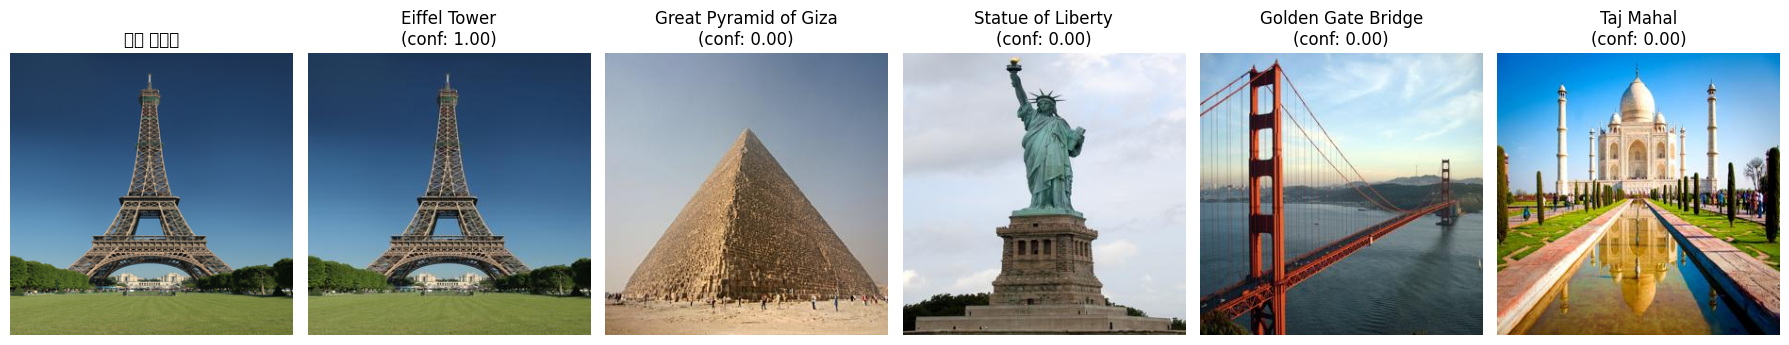

In [56]:
# matplotlib 으로 추천 결과 시각화
fig, axes = plt.subplots(1, 6, figsize=(18, 6))

# 원본 테스트 이미지
axes[0].imshow(images[0])
axes[0].set_title("입력 이미지")
axes[0].axis('off')

# Top-5 추천 이미지 및 이름 출력
for i, idx in enumerate(top5_idx):
    lid = label_set[idx]
    name = landmark_name_map.get(lid, "Unknown")
    # 저장된 이미지 불러오기
    img_path = os.path.join(img_dir, f"{df[df['landmark_id'] == lid]['id'].values[0]}.jpg")
    rec_img = Image.open(img_path)
    axes[i+1].imshow(rec_img)
    axes[i+1].set_title(f"{name}\n(conf: {pred[idx]:.2f})")
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()